In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import Tensor

from torchvision import transforms 

import os

from PIL import Image, ImageEnhance 
#library for image processing in Python. 


# Preprocessing
This is where we preprocess the data

### Load in data from directories

In [ ]:
paths = pd.read_csv("train_images.csv")

rgb_img = 0
for x in paths["image_path"]:
    # The dot makes it so that it's relative to your current dir,
    rgb_img = plt.imread("." + x)

plt.imshow(rgb_img)


: 

### Some exploration of the data

In [3]:
# temp 

data = pd.read_csv("/Users/micolcandoni/Documents/GitHub/AppliedMLProject/aml-2025-feathers-in-focus/train_images.csv")

data.head(10)

,image_path,label
0,/train_images/1.jpg,1
1,/train_images/2.jpg,1
2,/train_images/3.jpg,1
3,/train_images/4.jpg,1
4,/train_images/5.jpg,1
5,/train_images/6.jpg,1
6,/train_images/7.jpg,1
7,/train_images/8.jpg,1
8,/train_images/9.jpg,1
9,/train_images/10.jpg,1


In [17]:
print(data.size)

7852


In [4]:
from collections import Counter


#count how many images per label 

counts_labels = data['label'].value_counts().sort_index().reset_index()
counts_labels.columns = ['Label', 'Count']


for i in counts_labels.iterrows():
    print(i[1])

Label     1
Count    35
Name: 0, dtype: int64
Label     2
Count    35
Name: 1, dtype: int64
Label     3
Count    33
Name: 2, dtype: int64
Label     4
Count    35
Name: 3, dtype: int64
Label     5
Count    19
Name: 4, dtype: int64
Label     6
Count    16
Name: 5, dtype: int64
Label     7
Count    28
Name: 6, dtype: int64
Label     8
Count    23
Name: 7, dtype: int64
Label     9
Count    34
Name: 8, dtype: int64
Label    10
Count    34
Name: 9, dtype: int64
Label    11
Count    33
Name: 10, dtype: int64
Label    12
Count    31
Name: 11, dtype: int64
Label    13
Count    33
Name: 12, dtype: int64
Label    14
Count    33
Name: 13, dtype: int64
Label    15
Count    33
Name: 14, dtype: int64
Label    16
Count    33
Name: 15, dtype: int64
Label    17
Count    32
Name: 16, dtype: int64
Label    18
Count    20
Name: 17, dtype: int64
Label    19
Count    32
Name: 18, dtype: int64
Label    20
Count    32
Name: 19, dtype: int64
Label    21
Count    32
Name: 20, dtype: int64
Label    22
Count    31

In [5]:
print(counts_labels)

     Label  Count
0        1     35
1        2     35
2        3     33
3        4     35
4        5     19
..     ...    ...
195    196      6
196    197      5
197    198      5
198    199      5
199    200      5

[200 rows x 2 columns]


In [6]:
print(counts_labels['Label'].head())

0    1
1    2
2    3
3    4
4    5
Name: Label, dtype: int64


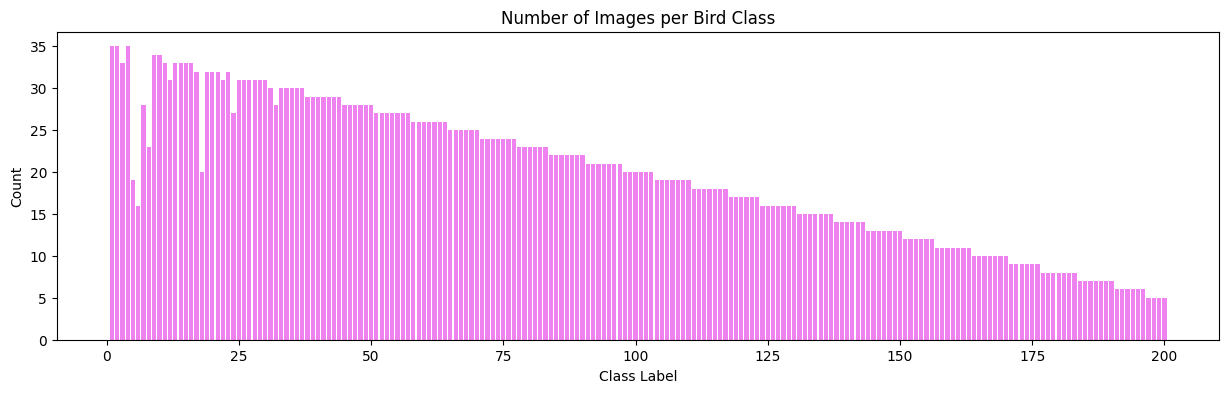

In [7]:
#viualise counts in a plot

import matplotlib.pyplot as plt

plt.figure(figsize = (15, 4))
plt.bar(counts_labels['Label'], counts_labels['Count'], color = 'violet')
plt.title("Number of Images per Bird Class")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [8]:
data['label'].value_counts().head()      # Most common

label
1     35
4     35
2     35
9     34
10    34
Name: count, dtype: int64

In [9]:
data['label'].value_counts().tail()      # Least common

label
196    6
197    5
198    5
199    5
200    5
Name: count, dtype: int64

### Make sure all data is in the same size

In [ ]:
# check CNN

### Potentially Data Augmentation

In [ ]:
# temp


# Training models

### Downloaded model

In [ ]:
# temp

### Simple model

In [3]:
# temp

### Complex model (enseble methods)

In [4]:
#temp

# Comparing models
Here we need to decide what metric to use in order to compare them.

In [ ]:
# temp

## Data Augmentation:

In [32]:
data_copy = data.copy()

> Creating a validation set (from train_images.csv)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, validate_data = train_test_split(
    data,
    test_size=0.2,
    stratify= data['label'],
    #to ensure that each bird class is represented fairly in both splits
    random_state= 42
)

train_data.to_csv("train_split.csv", index=False)
validate_data.to_csv("validate_split.csv", index=False)

In [11]:
print(train_data.head())

                  image_path  label
1249  /train_images/1250.jpg     42
3882  /train_images/3883.jpg    193
686    /train_images/687.jpg     23
1452  /train_images/1453.jpg     49
2357  /train_images/2358.jpg     85


In [12]:
print(validate_data.head())

                  image_path  label
2004  /train_images/2005.jpg     70
1711  /train_images/1712.jpg     59
2252  /train_images/2253.jpg     81
747    /train_images/748.jpg     25
2346  /train_images/2347.jpg     85


In [16]:
print(train_data.size)
print(validate_data.size)


6280
1572


> Printed to make sure that the dataset was correctly split (and to see what it looks like).

- Full dataset size: 7852
- Train set size: 6280
- Validate set size: 1572

> Now I will compute some Basic Image Data Augmentations on my train set, specifically Image Manipulation (ex:rotation, translation, shearing, flipping, cropping, noise injection, and colour space).

> According to the paper, things to look out for are: overly aggressive transformations (as this can risk confusing the model), mixing across classes to create ambiguous images, and overfitting (by relying too much on augmentations). 


In [ ]:
train_set = pd.read_csv("train_split.csv")

augmentation_output = "augmented_set"
os.makedirs(augmentation_output, exist_ok=True)

new_rows = []



def rotate(img, degrees = 15):
    return img.rotate(degrees)
#rotate the image by 15 degrees


def flip(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)
#flip image horizontally


def brighten(img, factor = 1.3):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(factor)
#increase brightness


def addnoise(img, amount = 10):
    array = np.array(img).astype(np.int16)
    noise = np.random.randint(-amount, amount, array.shape)
    array = np.clip(array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(array)
#add random noise (small)


def translate(img, shiftx = 15, shifty = 10):
    return img.transform(
        img.size, 
        Image.AFFINE,
        (1, 0, shiftx, 0, 1, shifty),
        resample = Image.BICUBIC,
        fillcolor = (0, 0, 0)
    )
#do translations (shift the image slightly as shown in the paper)


#create dictionary:
augmentations = {
    "rotate": lambda img: rotate(img, 15),
    "flip": lambda img: flip(img),
    "brighten": lambda img: brighten(img, 1.3),
    "noise": lambda img: addnoise(img),
    "translate": lambda img: translate(img, 15, 10)
}



#applying the 5 augmentation techniques to create new images (increase dataset size)

for index, row, in train_set.iterrows():
    image_path = row["image_path"].lstrip("/")
    label = row["label"]
    image = Image.open(image_path).convert("RGB")

    base_name = os.path.basename(image_path)
    name, extension = os.path.splitext(base_name)


    for augmented_name, augmented_function in augmentations.items():
        augmented_image = augmented_function(image)
        newfile = f"{name}_{augmented_name}{extension}"
        newpath = f"{augmentation_output}/{newfile}"

        augmented_image.save(newpath)

        new_rows.append({
            "image_path": newpath,
            "label": label
        })



#combining the original images + new rows to create bigger dataset

augmenteddf = pd.DataFrame(new_rows)
newdf = pd.concat([train_set, augmenteddf], ignore_index=True)

newdf.to_csv("train_augmented.csv", index=False)


In [26]:
print(newdf.head())
print(newdf.size)

               image_path  label
0  /train_images/1250.jpg     42
1  /train_images/3883.jpg    193
2   /train_images/687.jpg     23
3  /train_images/1453.jpg     49
4  /train_images/2358.jpg     85
37680


> printed to see what my new df looks like. Size is 37680, which confirms that augmentations worked correctly. 

>Initial amount = 6280 x 5 = 31400 + 6280 (original) = 37680

In [ ]:
df = pd.read_csv("train_augmented.csv")

# Remove leading slash ONLY 
df["image_path"] = df["image_path"].str.lstrip("/")

df.to_csv("train_augmented.csv", index=False)

> Now I can randomly select a picture and generate the augmentations to see how the augmentations look like compared to the original. Every time I run, a new image will be selected. 

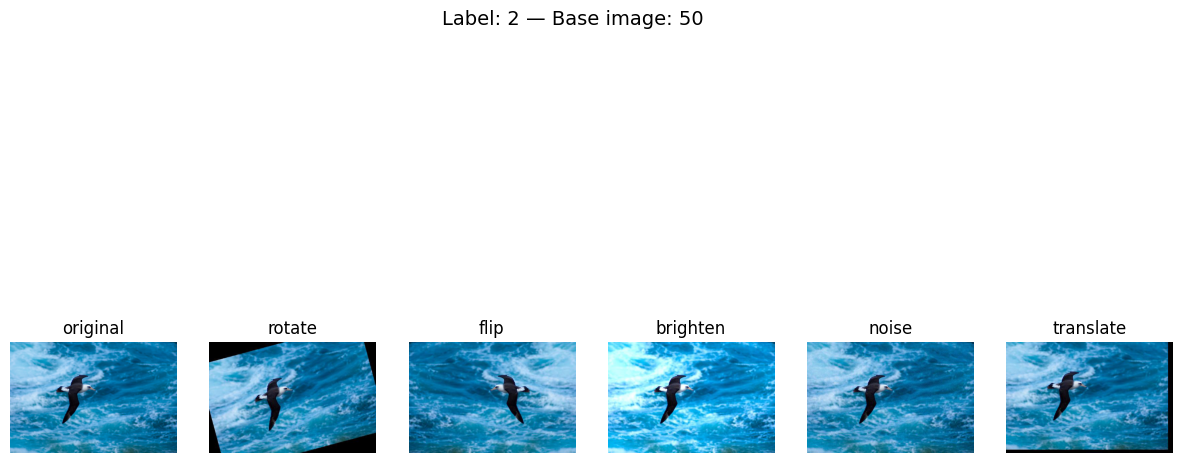

In [ ]:
import random

df = pd.read_csv("train_augmented.csv")

# Pick a random ORIGINAL image from train_set only (not from augmented_set)
df_original_only = df[df["image_path"].str.contains("train_images")]
random_row = df_original_only.sample(1).iloc[0]

orig_path = random_row["image_path"]
label = random_row["label"]

# Extract base name (ex: "1250")
base_name = os.path.splitext(os.path.basename(orig_path))[0]

# Build expected augmented filenames
aug_folder = "augmented_set"
aug_versions = {
    "rotate": f"{aug_folder}/{base_name}_rotate.jpg",
    "flip": f"{aug_folder}/{base_name}_flip.jpg",
    "brighten": f"{aug_folder}/{base_name}_brighten.jpg",
    "noise": f"{aug_folder}/{base_name}_noise.jpg",
    "translate": f"{aug_folder}/{base_name}_translate.jpg"
}

# Load images
images = {"original": Image.open(orig_path).convert("RGB")}
for aug_name, path in aug_versions.items():
    if os.path.exists(path):
        images[aug_name] = Image.open(path).convert("RGB")

# Plot images
plt.figure(figsize=(15, 8))
columns = len(images)
for i, (title, img) in enumerate(images.items(), start=1):
    plt.subplot(1, columns, i)
    plt.imshow(img)
    plt.title(title, fontsize=12)
    plt.axis("off")

plt.suptitle(f"Label: {label} — Base image: {base_name}", fontsize=14)
plt.show()
